In [1]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import scipy as stats
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import math 

In [4]:
df=pd.read_csv('fandango_score_comparison.csv')

In [5]:
df.rename(columns={'Metacritic_user_norm_round':'Metacritic_user_norm'},inplace=True)

# Parameter correlation coefficient

In [6]:
ranking_lst=['Fandango_Stars','RT_user_norm','RT_norm','IMDB_norm','Metacritic_user_norm','Metacritic_norm']

In [7]:
def my_heatmap(df):
    fig,axes=plt.subplots()
    sns.heatmap(df,annot=True)
    plt.show()
    plt.close()

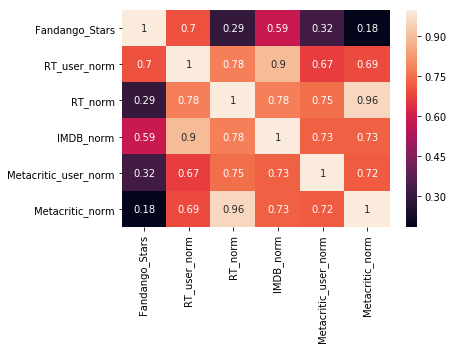

In [10]:
my_heatmap(df[ranking_lst].corr(method='pearson'))

Uwaga: jedna ze zmiennych jest skorelowana raz dodatnio, jednak przy ograniczeniu jej do pewnego podzbioru okazuje się, że jest ona skorelowana ujemnie. Należy się zastanowić czy nie wykluczyć jej z modelu

In [12]:
feature_cols=['Fandango_Stars','RT_user_norm','RT_norm','Metacritic_user_norm','Metacritic_norm']
X=df.loc[:,feature_cols]

In [16]:
y=df['IMDB_norm']

# Slitting data into train and test set

In [17]:
X_train, X_test, Y_train, Y_test=train_test_split(X,y,test_size=0.5,random_state=43) #random state is seed

In [18]:
dim=len(feature_cols)

In [19]:
dim +=1 #independent coefficient

In [21]:
#creating extra column for coefficient 
X_train=X_train.assign(independent=pd.Series([1]*len(Y_train),index=X_train.index))
X_test=X_test.assign(independent=pd.Series([1]*len(Y_test), index=X_test.index))

In [24]:
#It is more complicated to put Pandas dataframe into TF that's why we convert it into Panda array
P_train=X_train.as_matrix(columns=None)
P_test=X_test.as_matrix(columns=None)
q_train=np.array(Y_train.values).reshape(-1,1)
q_test=np.array(Y_test.values).reshape(-1,1)

In [31]:
P=tf.placeholder(tf.float32,[None,dim])
q=tf.placeholder(tf.float32,[None,1])
T=tf.Variable(tf.ones([dim,1]))

In [32]:
bias=tf.Variable(tf.constant(1.0,shape=[dim]))
q_=tf.add(tf.matmul(P,T),bias)

In [37]:
cost=tf.reduce_mean(tf.square(q_-q))
learning_rate=0.0001
training_op=tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

In [34]:
init_op=tf.global_variables_initializer()
cost_history=np.empty(shape=[1],dtype=float)

In [39]:
training_epochs=50000
with tf.Session() as sess:
    sess.run(init_op)
    cost_history=np.empty(shape=[1],dtype=float)
    t_history=np.empty(shape=[dim,1],dtype=float)
    for epoch in range(training_epochs):
        sess.run(training_op,feed_dict={P: P_train, q: q_train})
        cost_history=np.append(cost_history,sess.run(cost,feed_dict={P:P_train, q: q_train}))
        t_history=np.append(t_history,sess.run(T, feed_dict={P:P_train, q:q_train}),axis=1)
    q_pred=sess.run(q_,feed_dict={P: P_test})[:,0]
    mse=tf.reduce_mean(tf.square(q_pred-q_test))
    mse_temp=mse.eval()
    sess.close()

In [41]:
print(mse_temp)
RMSE=math.sqrt(mse_temp)
print(RMSE)

0.4294541566358531
0.6553275186010833


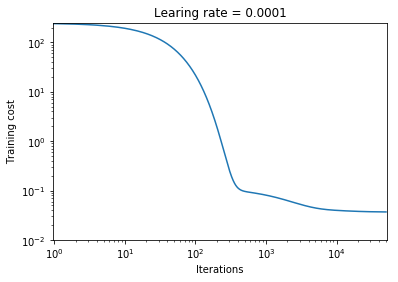

In [46]:
fig,axes=plt.subplots()
plt.plot(range(len(cost_history)),cost_history)
axes.set_xlim(xmin=0.95)
axes.set_ylim(ymin=1.e-2)
axes.set_xscale("log",nonposx='clip')
axes.set_yscale("log",nonposy='clip')
axes.set_xlabel('Iterations')
axes.set_ylabel('Training cost')
axes.set_title('Learing rate = '+str(learning_rate))
plt.show()
plt.close()

# Model evaluation

In [55]:
predictedDF=X_test.copy(deep=True)
predictedDF.insert(loc=0,column='IMDB_norm_predicted',value=pd.Series(data=q_pred,index=predictedDF.index))

predictedDF.insert(loc=0,column='IMBM_norm_actual',value=q_test)
print('Predicted vs actual using LR in TF')
print(predictedDF[['IMBM_norm_actual','IMDB_norm_predicted']].head())
print(predictedDF[['IMBM_norm_actual','IMDB_norm_predicted']].tail())

Predicted vs actual using LR in TF
     IMBM_norm_actual  IMDB_norm_predicted
45               3.30             3.200484
50               3.35             3.427913
98               3.05             2.907741
119              3.60             3.788512
133              2.15             2.524110
     IMBM_norm_actual  IMDB_norm_predicted
140              4.30             4.028998
143              3.70             3.797575
42               4.10             3.977932
90               3.05             3.249516
40               3.45             3.526335


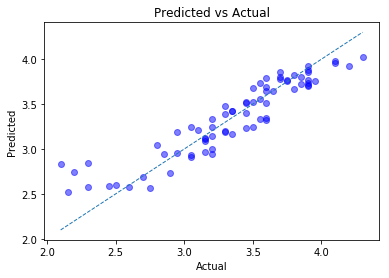

In [58]:
plt.scatter(q_test,q_pred,color='blue',alpha=0.5)
plt.plot([q_test.min(),q_test.max()],[q_test.min(),q_test.max()],'--',lw=1)
plt.title('Predicted vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
